# Imports

In [1]:
import gensim.downloader as api
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
import spacy


# This model is very heavy; it's 1662MB. It was trained on around 100 billion words and contains 300,000,000 vectors.
wv = api.load("word2vec-google-news-300")
glv = api.load("glove-twitter-25")

nlp = spacy.load("en_core_web_lg")

# Gensim Introduction

Similarity in terms of word embedding means that these words are found in similar contexts. 

ex.: "I was feeling good as I was on holiday." & "I was feeling bad as it was Monday." will have `good` and `bad` to be found quiet similar since they appear in the same kind of contexts. 

In [2]:
wv.similarity(w1="great", w2="good")

0.729151

In [3]:
wv.similarity(w1="profit", w2="loss")

0.34199455

In [4]:
print(wv.most_similar("good"))

[('great', 0.7291510105133057), ('bad', 0.7190051078796387), ('terrific', 0.6889115571975708), ('decent', 0.6837348341941833), ('nice', 0.6836092472076416), ('excellent', 0.644292950630188), ('fantastic', 0.6407778263092041), ('better', 0.6120728850364685), ('solid', 0.5806034803390503), ('lousy', 0.576420247554779)]


In [5]:
print(wv.most_similar("cat"))

[('cats', 0.8099379539489746), ('dog', 0.760945737361908), ('kitten', 0.7464985251426697), ('feline', 0.7326234579086304), ('beagle', 0.7150582671165466), ('puppy', 0.7075453400611877), ('pup', 0.6934291124343872), ('pet', 0.6891531348228455), ('felines', 0.6755931973457336), ('chihuahua', 0.6709762215614319)]


In [6]:
# France - Paris + Berlin = Germany 
# Country - its capital + capital of other country = other country
print(wv.most_similar(positive=["France", "Berlin"], negative=["Paris"]))

[('Germany', 0.7901254892349243), ('Austria', 0.6026812195777893), ('German', 0.6004959940910339), ('Germans', 0.5851002931594849), ('Poland', 0.5847075581550598), ('Hungary', 0.5271855592727661), ('BBC_Tristana_Moore', 0.5249711275100708), ('symbol_RSTI', 0.5245768427848816), ('Belgium', 0.5221248269081116), ('Germnay', 0.5199405550956726)]


In [7]:
# king - mqn + woman = queen
print(wv.most_similar(positive=["king", "woman"], negative=["man"]))

[('queen', 0.7118193507194519), ('monarch', 0.6189674139022827), ('princess', 0.5902431011199951), ('crown_prince', 0.5499460697174072), ('prince', 0.5377321839332581), ('kings', 0.5236844420433044), ('Queen_Consort', 0.5235945582389832), ('queens', 0.5181134343147278), ('sultan', 0.5098593831062317), ('monarchy', 0.5087411999702454)]


In [8]:
wv.doesnt_match(["Facebook", "cat", "Google", "Microsoft"])

'cat'

In [9]:
wv_great = wv["great"]
wv_good = wv["good"]

With twitter-vocabulary model

In [10]:
print(glv.most_similar("cat"))

[('dog', 0.9590820074081421), ('monkey', 0.920357882976532), ('bear', 0.9143136739730835), ('pet', 0.9108031392097473), ('girl', 0.8880629539489746), ('horse', 0.8872726559638977), ('kitty', 0.8870542049407959), ('puppy', 0.886769711971283), ('hot', 0.886525571346283), ('lady', 0.8845519423484802)]


In [11]:
print(glv.most_similar("good"))

[('too', 0.9648017287254333), ('day', 0.9533665180206299), ('well', 0.9503170847892761), ('nice', 0.9438973665237427), ('better', 0.9425962567329407), ('fun', 0.9418926239013672), ('much', 0.9413353800773621), ('this', 0.9387555122375488), ('hope', 0.9383506774902344), ('great', 0.9378516674041748)]


In [12]:
print(glv.most_similar(positive=["king", "woman"], negative=["man"]))

[('meets', 0.8841924071311951), ('prince', 0.832163393497467), ('queen', 0.8257461190223694), ('’s', 0.8174097537994385), ('crow', 0.813499391078949), ('hunter', 0.8131037950515747), ('father', 0.8115834593772888), ('soldier', 0.81113600730896), ('mercy', 0.8082392811775208), ('hero', 0.8082264065742493)]


# News Classification Using Gensim

## Data Preparation

In [14]:
fake = pd.read_csv("Fake.csv")
true = pd.read_csv("True.csv")

fake["label"] = "fake"
fake = fake[["text", "label"]]
true["label"] = "real"
true = true[["text", "label"]]

df = pd.concat([true, fake])
df["label_num"] = df["label"].map({"fake": 0, "real": 1})

In [15]:
df.head()

,text,label,label_num
0,WASHINGTON (Reuters) - The head of a conservat...,real,1
1,WASHINGTON (Reuters) - Transgender people will...,real,1
2,WASHINGTON (Reuters) - The special counsel inv...,real,1
3,WASHINGTON (Reuters) - Trump campaign adviser ...,real,1
4,SEATTLE/WASHINGTON (Reuters) - President Donal...,real,1


## Preprocessing

For a sentence, we get the vectors for each word, then average them.
Ex.:

worry -> [300-size vector]

understand -> [300-size vector]

Average-> [300-size vector] = sentence embedding

In [ ]:
v1 = wv["worry"]
v2 = wv["understand"]

print(np.mean([v1, v2], axis=0) == wv.get_mean_vector([v1, v2], pre_normalize=False))

In [32]:
def preprocess_and_vectorize(text):
    doc = nlp(text)
    filtered_token = list()
    for token in doc:
        if token.is_punct or token.is_stop:
            continue
        filtered_token.append(token.lemma_)
    return wv.get_mean_vector(filtered_token)

## Word Embedding

In [ ]:
df["vector"] = df["text"].apply(preprocess_and_vectorize)

In [ ]:
df.head()

,text,label,label_num,vector
0,WASHINGTON (Reuters) - The head of a conservat...,real,1,"[0.016517185, 0.008581842, 0.003476052, 0.0377..."
1,WASHINGTON (Reuters) - Transgender people will...,real,1,"[-0.0068386164, 0.007986412, 0.011067564, 0.02..."
2,WASHINGTON (Reuters) - The special counsel inv...,real,1,"[0.0037878796, 0.010377998, 0.0042117573, 0.00..."
3,WASHINGTON (Reuters) - Trump campaign adviser ...,real,1,"[-0.0037526398, 0.005959125, -0.0018782298, -0..."
4,SEATTLE/WASHINGTON (Reuters) - President Donal...,real,1,"[0.009479425, 0.0015944116, -0.01082619, 0.023..."


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df["vector"].values, 
    df["label_num"],
    test_size=0.2,
    random_state=42,
    stratify=df["label_num"]
)

In [ ]:
# Reshaping to fit model

X_train_2d = np.stack(X_train)
X_test_2d = np.stack(X_test)

In [ ]:
clf = GradientBoostingClassifier()
clf.fit(X_train_2d, y_train)

y_pred = clf.predict(X_test_2d)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.97      0.96      0.97      4696
           1       0.95      0.97      0.96      4284

    accuracy                           0.96      8980
   macro avg       0.96      0.96      0.96      8980
weighted avg       0.96      0.96      0.96      8980



## Visualization

Text(120.72222222222221, 0.5, 'True Labels')

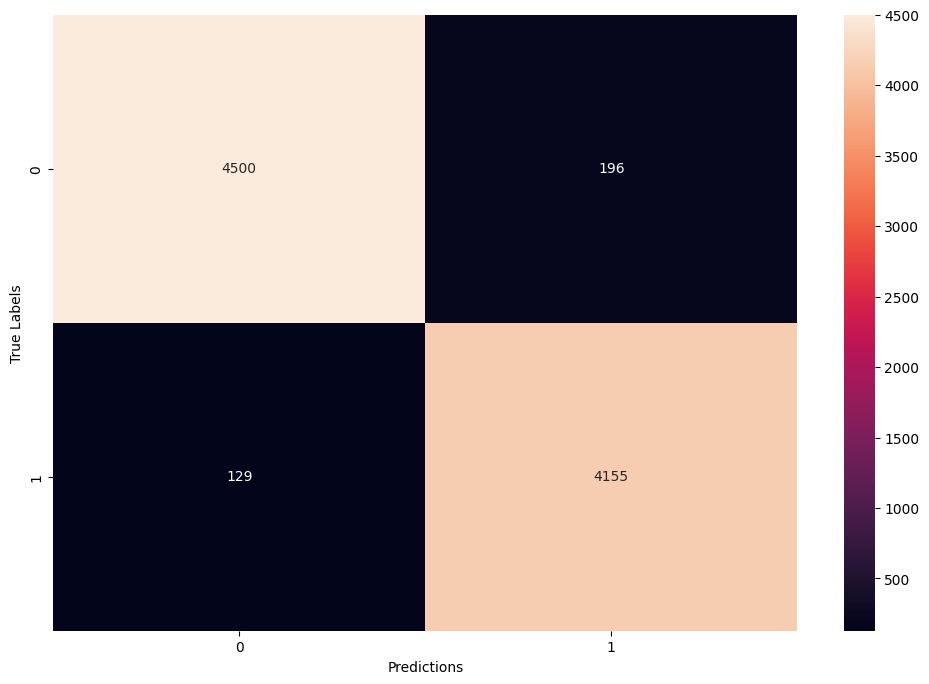

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel("Predictions")
plt.ylabel("True Labels")